In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

In [3]:
# Specify the path to your CSV file
file_path = r'C:\Users\manda\Documents\Master thesis Data\Maryland QC Work\Maryland QC 1indcal.csv'


# Try different encodings until you find the right one
encodings = ['utf-8', 'latin1', 'utf-16']

for encoding in encodings:
    try:
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path, encoding=encoding)
        # Display the DataFrame
        print(df)
        break
    except UnicodeDecodeError:
        print(f"Failed to decode using encoding: {encoding}")

# Display the DataFrame
print(df)

       year  month  day    prcp  tmax  tmin
0      1868      1    1 -99.900 -99.9 -99.9
1      1868      1    2 -99.900 -99.9 -99.9
2      1868      1    3 -99.900 -99.9 -99.9
3      1868      1    4 -99.900 -99.9 -99.9
4      1868      1    5 -99.900 -99.9 -99.9
...     ...    ...  ...     ...   ...   ...
10953  1897     12   27   0.000  21.1  14.4
10954  1897     12   28   1.524  20.6  14.4
10955  1897     12   29  58.420  21.1  13.3
10956  1897     12   30  28.956  21.7  14.4
10957  1897     12   31  26.162  17.2  13.3

[10958 rows x 6 columns]
       year  month  day    prcp  tmax  tmin
0      1868      1    1 -99.900 -99.9 -99.9
1      1868      1    2 -99.900 -99.9 -99.9
2      1868      1    3 -99.900 -99.9 -99.9
3      1868      1    4 -99.900 -99.9 -99.9
4      1868      1    5 -99.900 -99.9 -99.9
...     ...    ...  ...     ...   ...   ...
10953  1897     12   27   0.000  21.1  14.4
10954  1897     12   28   1.524  20.6  14.4
10955  1897     12   29  58.420  21.1  13.3
10956 

In [4]:
# Count missing values in each column marked as -99.9
missing_values_count = (df == -99.9).sum()

# Display the result
print("Number of missing values (-99.9) in each column:")
print(missing_values_count)


Number of missing values (-99.9) in each column:
year        0
month       0
day         0
prcp      230
tmax     2024
tmin     1761
dtype: int64


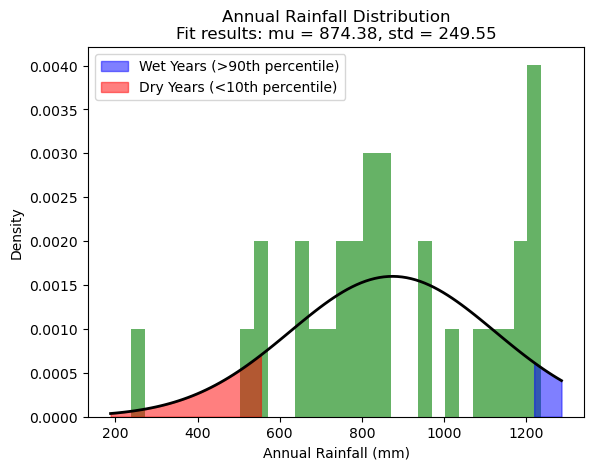

Wet Years (Annual Rainfall > 90th percentile):
Int64Index([1870, 1879, 1897], dtype='int64', name='year')

Dry Years (Annual Rainfall < 10th percentile):
Int64Index([1868, 1881, 1888], dtype='int64', name='year')

Rainfall Thresholds:
90th percentile: 1210.91 mm
10th percentile: 564.74 mm


In [15]:
from scipy.stats import norm 
# Filter out rows with PRCP values equal to -99.9
filtered_df = df[df['prcp'] != -99.9]

# Calculate the annual total rainfall for each year
annual_rainfall = filtered_df.groupby('year')['prcp'].sum()

# Step 1: Plot Gaussian Distribution
mu, std = norm.fit(annual_rainfall)

# Plot the histogram
plt.hist(annual_rainfall, bins=30, density=True, alpha=0.6, color='g')

# Plot the PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

title = "Annual Rainfall Distribution\nFit results: mu = %.2f, std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('Annual Rainfall (mm)')
plt.ylabel('Density')

# Step 2 & 3: Identify wet and dry years based on percentiles and plot
percentile_90th = np.percentile(annual_rainfall, 90)
percentile_10th = np.percentile(annual_rainfall, 10)

wet_years = annual_rainfall[annual_rainfall > percentile_90th].index
dry_years = annual_rainfall[annual_rainfall < percentile_10th].index

# Highlighting areas for wet and dry years
plt.fill_between(x, 0, p, where=(x > percentile_90th), color='blue', alpha=0.5, label='Wet Years (>90th percentile)')
plt.fill_between(x, 0, p, where=(x < percentile_10th), color='red', alpha=0.5, label='Dry Years (<10th percentile)')

plt.legend()
plt.show()

# Printing wet and dry years
print("Wet Years (Annual Rainfall > 90th percentile):")
print(wet_years)

print("\nDry Years (Annual Rainfall < 10th percentile):")
print(dry_years)

# Printing threshold values
print("\nRainfall Thresholds:")
print(f"90th percentile: {percentile_90th:.2f} mm")
print(f"10th percentile: {percentile_10th:.2f} mm")

In [17]:
# Function to filter out months based on missing values for tmax and tmin
def filter_months(df, missing_threshold=5, consecutive_missing_threshold=3):
    filtered_tmax_months = []
    filtered_tmin_months = []
    for year in df['year'].unique():
        for month in df[df['year'] == year]['month'].unique():
            month_data = df[(df['year'] == year) & (df['month'] == month)]
            missing_tmax_count = month_data['tmax'].eq(-99.9).sum()
            missing_tmin_count = month_data['tmin'].eq(-99.9).sum()
            if missing_tmax_count > missing_threshold:
                filtered_tmax_months.append((year, month))
            else:
                consecutive_missing_tmax = 0
                for i in range(len(month_data['tmax'])):
                    if month_data['tmax'].iloc[i] == -99.9:
                        consecutive_missing_tmax += 1
                        if consecutive_missing_tmax >= consecutive_missing_threshold:
                            filtered_tmax_months.append((year, month))
                            break
                    else:
                        consecutive_missing_tmax = 0
            if missing_tmin_count > missing_threshold:
                filtered_tmin_months.append((year, month))
            else:
                consecutive_missing_tmin = 0
                for i in range(len(month_data['tmin'])):
                    if month_data['tmin'].iloc[i] == -99.9:
                        consecutive_missing_tmin += 1
                        if consecutive_missing_tmin >= consecutive_missing_threshold:
                            filtered_tmin_months.append((year, month))
                            break
                    else:
                        consecutive_missing_tmin = 0
    return filtered_tmax_months, filtered_tmin_months

filtered_tmax_months, filtered_tmin_months = filter_months(df, missing_threshold=5, consecutive_missing_threshold=3)
print("Filtered Tmax Months:", filtered_tmax_months)
print("Filtered Tmin Months:", filtered_tmin_months)

Filtered Tmax Months: [(1868, 8), (1868, 9), (1868, 10), (1868, 11), (1868, 12), (1869, 1), (1869, 2), (1869, 3), (1869, 4), (1869, 5), (1869, 6), (1869, 7), (1869, 8), (1869, 9), (1869, 10), (1869, 11), (1869, 12), (1870, 1), (1870, 2), (1870, 3), (1870, 4), (1870, 5), (1870, 6), (1870, 7), (1870, 8), (1870, 9), (1870, 10), (1870, 11), (1870, 12), (1871, 1), (1871, 2), (1871, 3), (1871, 4), (1871, 5), (1871, 6), (1871, 7), (1871, 8), (1871, 9), (1871, 10), (1871, 11), (1871, 12), (1872, 1), (1872, 2), (1872, 3), (1872, 4), (1872, 5), (1872, 6), (1872, 7), (1872, 8), (1872, 9), (1872, 10), (1872, 11), (1872, 12), (1873, 6), (1874, 8), (1874, 11), (1883, 10), (1883, 11), (1890, 2), (1890, 3), (1893, 3), (1893, 4), (1893, 5), (1893, 6), (1893, 12)]
Filtered Tmin Months: [(1868, 8), (1868, 9), (1868, 10), (1868, 11), (1868, 12), (1869, 1), (1869, 2), (1869, 3), (1869, 4), (1869, 5), (1869, 6), (1869, 7), (1869, 8), (1869, 9), (1869, 10), (1869, 11), (1869, 12), (1870, 1), (1870, 2), (1870

In [19]:
pip install tabulate


Note: you may need to restart the kernel to use updated packages.


In [20]:
from tabulate import tabulate
# Print filtered months in tabular format
print("Filtered Tmax Months:")
print(tabulate(filtered_tmax_months, headers=['Year', 'Month']))
print("\nFiltered Tmin Months:")
print(tabulate(filtered_tmin_months, headers=['Year', 'Month']))

Filtered Tmax Months:
  Year    Month
------  -------
  1868        8
  1868        9
  1868       10
  1868       11
  1868       12
  1869        1
  1869        2
  1869        3
  1869        4
  1869        5
  1869        6
  1869        7
  1869        8
  1869        9
  1869       10
  1869       11
  1869       12
  1870        1
  1870        2
  1870        3
  1870        4
  1870        5
  1870        6
  1870        7
  1870        8
  1870        9
  1870       10
  1870       11
  1870       12
  1871        1
  1871        2
  1871        3
  1871        4
  1871        5
  1871        6
  1871        7
  1871        8
  1871        9
  1871       10
  1871       11
  1871       12
  1872        1
  1872        2
  1872        3
  1872        4
  1872        5
  1872        6
  1872        7
  1872        8
  1872        9
  1872       10
  1872       11
  1872       12
  1873        6
  1874        8
  1874       11
  1883       10
  1883       11
  1890        2
  

C:\Users\manda\AppData\Local\Temp\ipykernel_21368\1759316525.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['daily_mean_temp'] = (cleaned_df['tmax'] + cleaned_df['tmin']) / 2


Hot Years:
Int64Index([1877, 1878, 1884, 1885, 1886, 1889], dtype='int64', name='year')

Cold Years:
Int64Index([1873, 1890, 1891, 1894], dtype='int64', name='year')


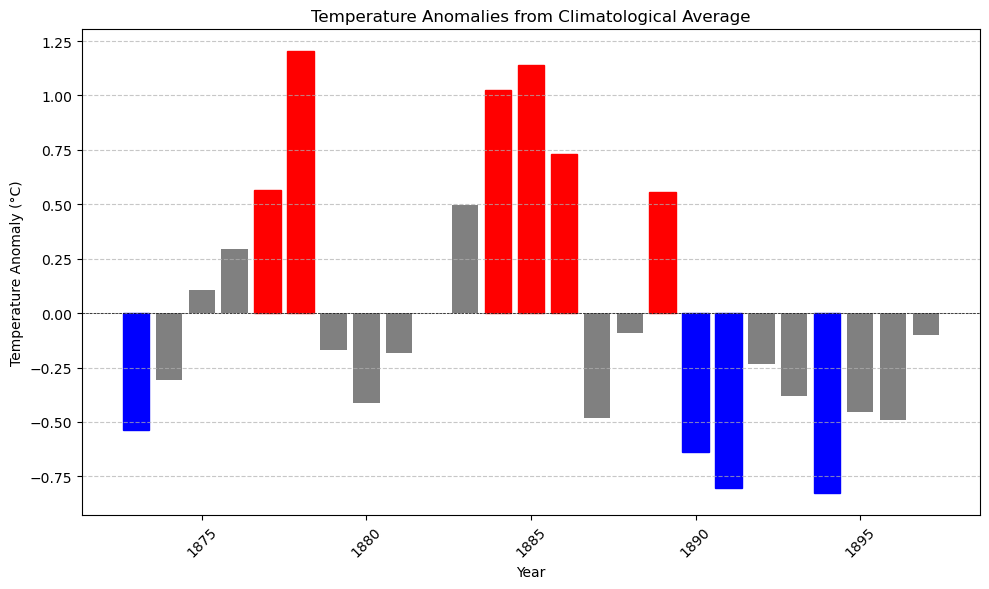

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing temperature data

# Exclude rows with -99.9 values for both tmax and tmin
cleaned_df = df[(df['tmax'] != -99.9) & (df['tmin'] != -99.9)]

# Calculate daily mean temperature
cleaned_df['daily_mean_temp'] = (cleaned_df['tmax'] + cleaned_df['tmin']) / 2

# Calculate annual average temperature
annual_avg_temp = cleaned_df.groupby('year')['daily_mean_temp'].mean()

# Calculate temperature anomalies compared to the climatological average 
climatological_avg = annual_avg_temp.mean()
temperature_anomalies = annual_avg_temp - climatological_avg

# Define thresholds for hot and cold years
hot_threshold = 0.5
cold_threshold = -0.5

# Identify hot and cold years based on temperature anomalies
hot_years = temperature_anomalies[temperature_anomalies > hot_threshold].index
cold_years = temperature_anomalies[temperature_anomalies < cold_threshold].index

# Print hot and cold years
print("Hot Years:")
print(hot_years)
print("\nCold Years:")
print(cold_years)

# Plotting
plt.figure(figsize=(10, 6))

# Plot gray bars for all years
bars = plt.bar(temperature_anomalies.index, temperature_anomalies.values, color='gray')

# Highlight hot and cold years
for bar in bars:
    year = bar.get_height()
    if year > hot_threshold:
        bar.set_color('red')  # Red for hot years
    elif year < cold_threshold:
        bar.set_color('blue')  # Blue for cold years

plt.axhline(0, color='black', linestyle='--', linewidth=0.5)  # Add horizontal line at y=0 for reference
plt.title('Temperature Anomalies from Climatological Average')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


C:\Users\manda\AppData\Local\Temp\ipykernel_21368\4223546084.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['daily_mean_temp'] = (cleaned_df['tmax'] + cleaned_df['tmin']) / 2


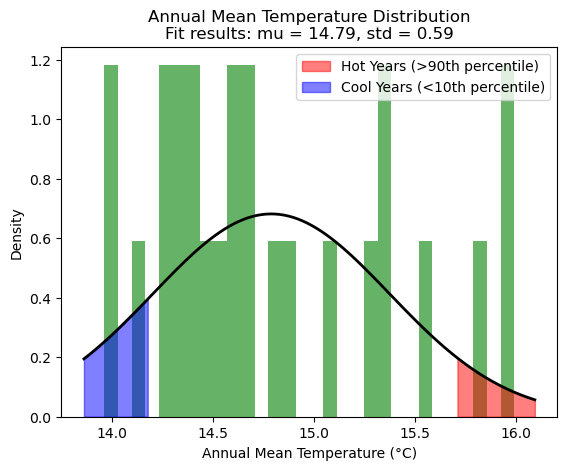

Hot Years (Annual Mean Temperature > 90th percentile):
Int64Index([1878, 1884, 1885], dtype='int64', name='year')

Cool Years (Annual Mean Temperature < 10th percentile):
Int64Index([1890, 1891, 1894], dtype='int64', name='year')

Temperature thresholds:
90th percentile: 15.70°C
10th percentile: 14.19°C


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming 'df' is your DataFrame

# Filter out rows with -99.9 values
cleaned_df = df[(df['tmax'] != -99.9) & (df['tmin'] != -99.9)]

# Calculate daily mean temperature
cleaned_df['daily_mean_temp'] = (cleaned_df['tmax'] + cleaned_df['tmin']) / 2

# Calculate annual mean temperature for each year
annual_mean_temp = cleaned_df.groupby('year')['daily_mean_temp'].mean()

# Step 1: Plot Gaussian Distribution
mu, std = norm.fit(annual_mean_temp)

# Plot the histogram
plt.hist(annual_mean_temp, bins=30, density=True, alpha=0.6, color='g')

# Plot the PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

title = "Annual Mean Temperature Distribution\nFit results: mu = %.2f, std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('Annual Mean Temperature (°C)')
plt.ylabel('Density')

# Step 2 & 3: Identify hot and cool years based on percentiles and plot
percentile_90th = np.percentile(annual_mean_temp, 90)
percentile_10th = np.percentile(annual_mean_temp, 10)

hot_years = annual_mean_temp[annual_mean_temp > percentile_90th].index
cool_years = annual_mean_temp[annual_mean_temp < percentile_10th].index

# Highlighting areas for hot and cool years
plt.fill_between(x, 0, p, where=(x > percentile_90th), color='red', alpha=0.5, label='Hot Years (>90th percentile)')
plt.fill_between(x, 0, p, where=(x < percentile_10th), color='blue', alpha=0.5, label='Cool Years (<10th percentile)')

plt.legend()
plt.show()

# Printing hot and cool years
print("Hot Years (Annual Mean Temperature > 90th percentile):")
print(hot_years)

print("\nCool Years (Annual Mean Temperature < 10th percentile):")
print(cool_years)

# Printing threshold values
print("\nTemperature thresholds:")
print(f"90th percentile: {percentile_90th:.2f}°C")
print(f"10th percentile: {percentile_10th:.2f}°C")

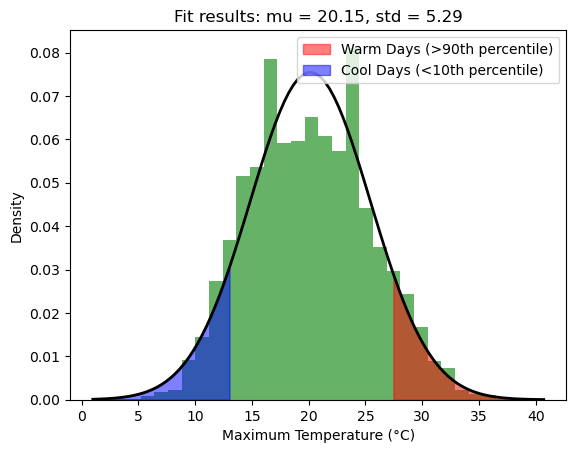

Percentage of days with maximum temperature > 90th percentile (Warm Days): 9.19%
Percentage of days with maximum temperature < 10th percentile (Cool Days): 8.72%
Temperature threshold for warm days (> 90th percentile): 27.20°C
Percentage of days with maximum temperature > 90th percentile: 9.19%
Temperature threshold for cool days (< 10th percentile): 13.30°C
Percentage of days with maximum temperature < 10th percentile: 8.72%


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming 'df' is your DataFrame and it contains a column 'Maximum.Temp..C.' for maximum temperatures

# Remove rows where maximum temperature is -99.9 (missing values)
cleaned_df = df[df['tmax'] != -99.9]

# Step 1: Plot Gaussian Distribution
mu, std = norm.fit(cleaned_df['tmax'])

# Plot the histogram
plt.hist(cleaned_df['tmax'], bins=30, density=True, alpha=0.6, color='g')

# Plot the PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

title = "Fit results: mu = %.2f, std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('Maximum Temperature (°C)')
plt.ylabel('Density')

# Step 2 & 3: Identify extreme warm and cool days and calculate percentages
percentile_90th = np.percentile(cleaned_df['tmax'], 90)
percentile_10th = np.percentile(cleaned_df['tmax'], 10)

warm_days_percentage = (cleaned_df['tmax'] > percentile_90th).mean() * 100
cool_days_percentage = (cleaned_df['tmax'] < percentile_10th).mean() * 100

# Highlighting areas for warm and cool days
plt.fill_between(x, 0, p, where=(x>percentile_90th), color='red', alpha=0.5, label='Warm Days (>90th percentile)')
plt.fill_between(x, 0, p, where=(x<percentile_10th), color='blue', alpha=0.5, label='Cool Days (<10th percentile)')

plt.legend()
plt.show()

# Printing percentages
print(f"Percentage of days with maximum temperature > 90th percentile (Warm Days): {warm_days_percentage:.2f}%")
print(f"Percentage of days with maximum temperature < 10th percentile (Cool Days): {cool_days_percentage:.2f}%")

# Printing the temperature thresholds along with percentages
print(f"Temperature threshold for warm days (> 90th percentile): {percentile_90th:.2f}°C")
print(f"Percentage of days with maximum temperature > 90th percentile: {warm_days_percentage:.2f}%")

print(f"Temperature threshold for cool days (< 10th percentile): {percentile_10th:.2f}°C")
print(f"Percentage of days with maximum temperature < 10th percentile: {cool_days_percentage:.2f}%")


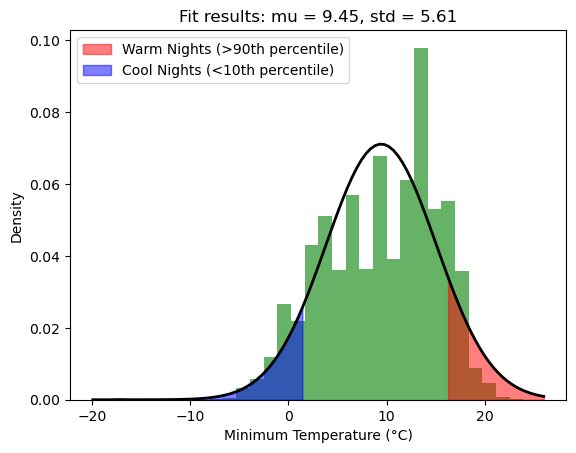

Percentage of days with minimum temperature > 90th percentile (Warm Nights): 9.20%
Percentage of days with minimum temperature < 10th percentile (Cool Nights): 9.81%
Temperature threshold for warm Nights (> 90th percentile): 16.10°C
Percentage of days with minimum temperature > 90th percentile: 9.20%
Temperature threshold for cool Nights (< 10th percentile): 1.70°C
Percentage of days with minimum temperature < 10th percentile: 9.81%


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming 'df' is your DataFrame and it contains a column 'Maximum.Temp..C.' for maximum temperatures

# Remove rows where maximum temperature is -99.9 (missing values)
cleaned_df = df[df['tmin'] != -99.9]

# Step 1: Plot Gaussian Distribution
mu, std = norm.fit(cleaned_df['tmin'])

# Plot the histogram
plt.hist(cleaned_df['tmin'], bins=30, density=True, alpha=0.6, color='g')

# Plot the PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

title = "Fit results: mu = %.2f, std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('Minimum Temperature (°C)')
plt.ylabel('Density')

# Step 2 & 3: Identify extreme warm and cool days and calculate percentages
percentile_90th = np.percentile(cleaned_df['tmin'], 90)
percentile_10th = np.percentile(cleaned_df['tmin'], 10)

warm_nights_percentage = (cleaned_df['tmin'] > percentile_90th).mean() * 100
cool_nights_percentage = (cleaned_df['tmin'] < percentile_10th).mean() * 100

# Highlighting areas for warm and cool days
plt.fill_between(x, 0, p, where=(x>percentile_90th), color='red', alpha=0.5, label='Warm Nights (>90th percentile)')
plt.fill_between(x, 0, p, where=(x<percentile_10th), color='blue', alpha=0.5, label='Cool Nights (<10th percentile)')

plt.legend()
plt.show()

# Printing percentages
print(f"Percentage of days with minimum temperature > 90th percentile (Warm Nights): {warm_nights_percentage:.2f}%")
print(f"Percentage of days with minimum temperature < 10th percentile (Cool Nights): {cool_nights_percentage:.2f}%")

# Printing the temperature thresholds along with percentages
print(f"Temperature threshold for warm Nights (> 90th percentile): {percentile_90th:.2f}°C")
print(f"Percentage of days with minimum temperature > 90th percentile: {warm_nights_percentage:.2f}%")

print(f"Temperature threshold for cool Nights (< 10th percentile): {percentile_10th:.2f}°C")
print(f"Percentage of days with minimum temperature < 10th percentile: {cool_nights_percentage:.2f}%")


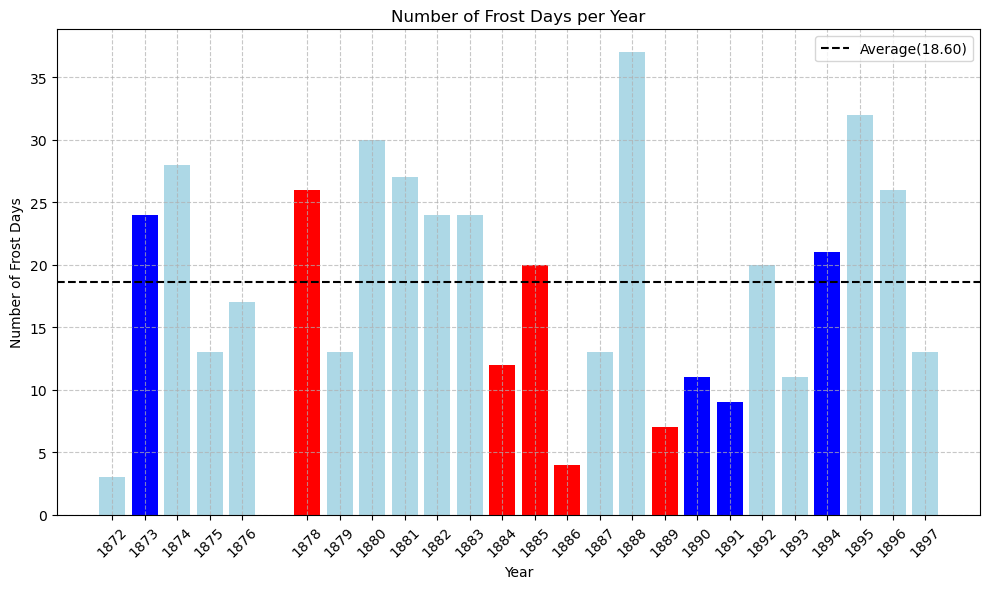

Linear Regression Results for Frost Days:
Slope Estimate: -0.012820512820512841
Slope Error: 0.24785523891775088
R-squared Value: 0.00011631513647642707
P-value: 0.9591937948557325


In [23]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Remove rows with -99.9 values
filtered_df = df[df['tmin'] != -99.9]

# Remove years 1877 and 1922
filtered_df = filtered_df[(filtered_df['year'] != 1877) & (filtered_df['year'] != 1922)]

# Filter for days where minimum temperature is less than 0°C
frost_days = filtered_df[filtered_df['tmin'] < 0]

# Count the number of frost nights for each year
frost_days_count = frost_days.groupby('year').size()

# Calculate the average value
average_value_frost = frost_days_count.mean()


Hot_Years = [1877,1878, 1884, 1885, 1886,1889]
Cold_Years = [1873, 1890, 1891,1894]

# Plotting
plt.figure(figsize=(10, 6))
bar_colors = ['lightblue' if year not in Hot_Years and year not in Cold_Years else 'red' if year in Hot_Years else 'blue' for year in frost_days_count.index]
plt.bar(frost_days_count.index, frost_days_count.values, color=bar_colors)

plt.axhline(y=average_value_frost, color='black', linestyle='--', label=f'Average({average_value_frost:.2f})')

plt.title('Number of Frost Days per Year')
plt.xlabel('Year')
plt.ylabel('Number of Frost Days')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.xticks(frost_days_count.index, rotation=45)  # Set x-ticks to be the years in the data
plt.legend()
plt.tight_layout()
plt.show()

# Calculate linear regression
x_frost = frost_days_count.index.values
y_frost = frost_days_count.values
slope_frost, intercept_frost, r_value_frost, p_value_frost, std_err_frost = stats.linregress(x_frost, y_frost)

# Calculate R-squared value
r_squared_frost = r_value_frost ** 2

print("Linear Regression Results for Frost Days:")
print(f"Slope Estimate: {slope_frost}")
print(f"Slope Error: {std_err_frost}")
print(f"R-squared Value: {r_squared_frost}")
print(f"P-value: {p_value_frost}")


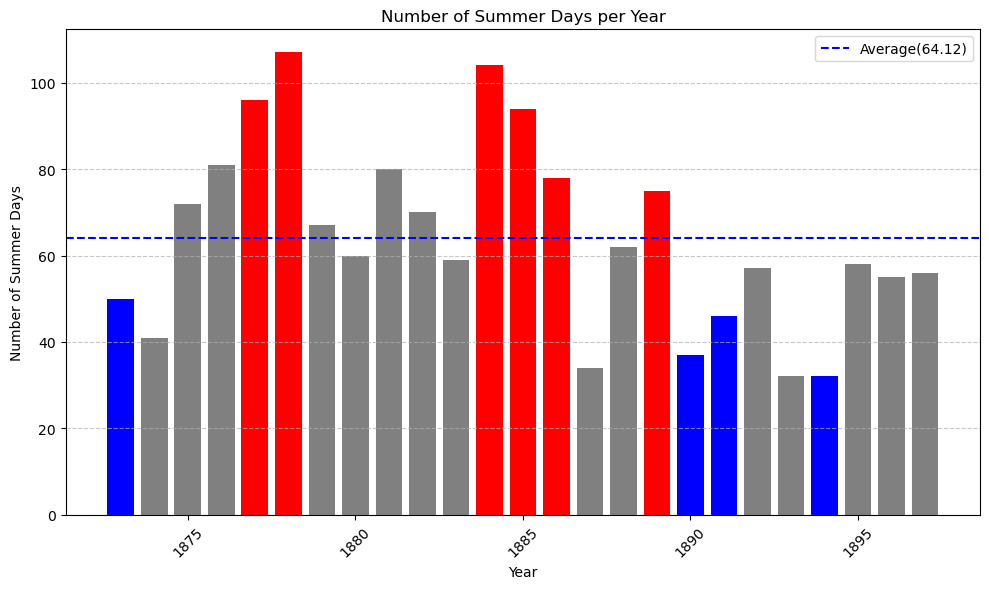

Linear Regression Results for Summer Days:
Slope Estimate: -1.213846153846154
Slope Error: 0.5615670492562697
R-squared Value: 0.16884178173738712
P-value: 0.04130424063474788


In [11]:
import numpy as np
import scipy.stats as stats

# Remove rows with -99.9 values
filtered_df = df[df['tmax'] != -99.9]


# Filter for days where maximum temperature is greater than 25°C
summer_days = filtered_df[filtered_df['tmax'] > 25]

# Count the number of summer days for each year
summer_days_count = summer_days.groupby('year').size()

# Calculate the average value
average_value_summer = summer_days_count.mean()

Hot_Years = [1877,1878, 1884, 1885, 1886,1889]
Cold_Years = [1873, 1890, 1891,1894]

# Plotting
plt.figure(figsize=(10, 6))

bar_colors = ['Grey' if year not in Hot_Years and year not in Cold_Years else 'red' if year in Hot_Years else 'blue' for year in summer_days_count.index]
plt.bar(summer_days_count.index, summer_days_count.values, color=bar_colors)
plt.axhline(y=average_value_summer, color='blue', linestyle='--', label=f'Average({average_value_summer:.2f})')
plt.title('Number of Summer Days per Year')
plt.xlabel('Year')
plt.ylabel('Number of Summer Days')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Calculate linear regression
x_summer = summer_days_count.index.values
y_summer = summer_days_count.values
slope_summer, intercept_summer, r_value_summer, p_value_summer, std_err_summer = stats.linregress(x_summer, y_summer)

# Calculate R-squared value
r_squared_summer = r_value_summer ** 2

print("Linear Regression Results for Summer Days:")
print(f"Slope Estimate: {slope_summer}")
print(f"Slope Error: {std_err_summer}")
print(f"R-squared Value: {r_squared_summer}")
print(f"P-value: {p_value_summer}")

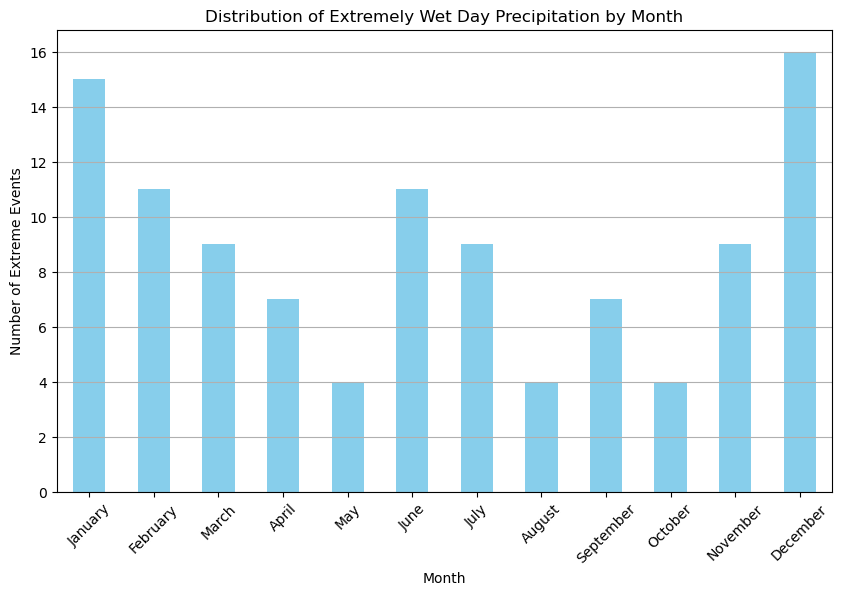

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming df is already loaded with the correct data, as shown in your code
# Exclude the years 1877 and 1922
df = df[df['prcp'] != -99.9] 

# Calculate the 95th and 99th percentiles for daily precipitation
percentile_95 = np.percentile(df['prcp'], 95)
percentile_99 = np.percentile(df['prcp'], 99)

# Filter for Very Wet Day and Extremely Wet Day Precipitation
very_wet_days = df[df['prcp'] > percentile_95]
extremely_wet_days = df[df['prcp'] > percentile_99]


# Count the number of extremely wet days by month
monthly_extreme_events = extremely_wet_days['month'].value_counts().sort_index()

# Convert month numbers to month names for readability
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
               7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
monthly_extreme_events.index = monthly_extreme_events.index.map(month_names)

# Plot the distribution
plt.figure(figsize=(10, 6))
monthly_extreme_events.plot(kind='bar', color='skyblue')
plt.title('Distribution of Extremely Wet Day Precipitation by Month')
plt.xlabel('Month')
plt.ylabel('Number of Extreme Events')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()

C:\Users\manda\AppData\Local\Temp\ipykernel_21368\1993527879.py:21: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for year, rainfall in annual_total_rainfall.iteritems():


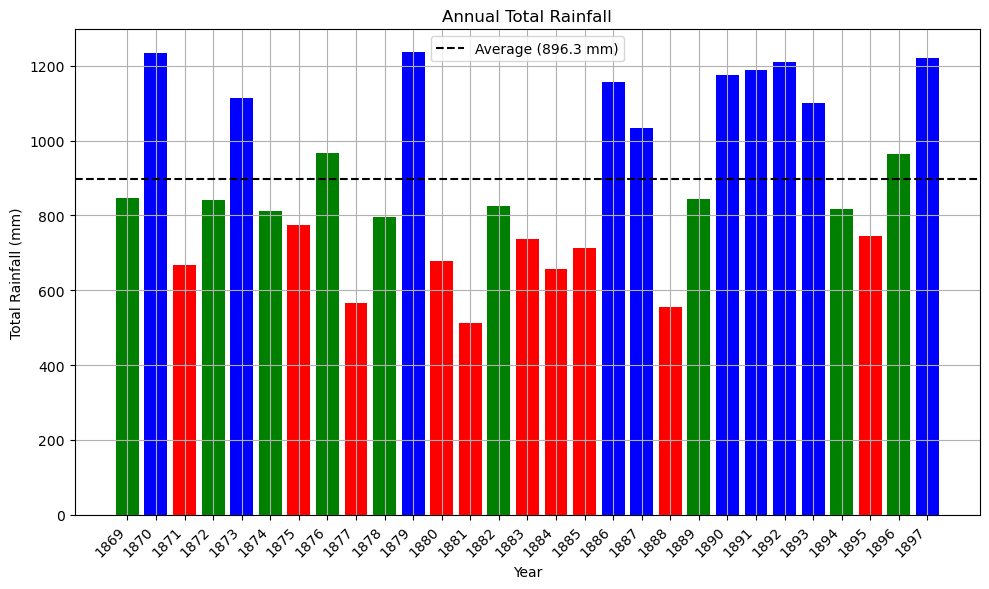

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

df = df[(df['prcp'] != -99.9) & (df['year']!=1868)] 


# Aggregate total rainfall values for each year
annual_total_rainfall = df.groupby('year')['prcp'].sum()

# Calculate average total annual rainfall and standard deviation
average_annual_rainfall = annual_total_rainfall.mean()
std_annual_rainfall = annual_total_rainfall.std()

# Plot the graph for annual total rainfall with average line
plt.figure(figsize=(10, 6))

# Plot average line
plt.axhline(average_annual_rainfall, color='black', linestyle='--', label=f'Average ({average_annual_rainfall:.1f} mm)')

# Plot annual total rainfall bars
for year, rainfall in annual_total_rainfall.iteritems():
    deviation = rainfall - average_annual_rainfall
    if deviation <= -0.5 * std_annual_rainfall:
        color = 'red'
    elif deviation >= 0.5 * std_annual_rainfall:
        color = 'blue'
    else:
        color = 'green'
    plt.bar(year, rainfall, color=color)

plt.title('Annual Total Rainfall')
plt.xlabel('Year')
plt.ylabel('Total Rainfall (mm)')
plt.grid(True)
plt.xticks(annual_total_rainfall.index,rotation=45, ha='right')  # Rotate x-axis ticks for better readability
plt.legend()
plt.tight_layout()
plt.show()


Filtered Months: []


C:\Users\manda\AppData\Local\Temp\ipykernel_21368\558104676.py:45: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for year, rainfall in annual_total_rainfall.iteritems():


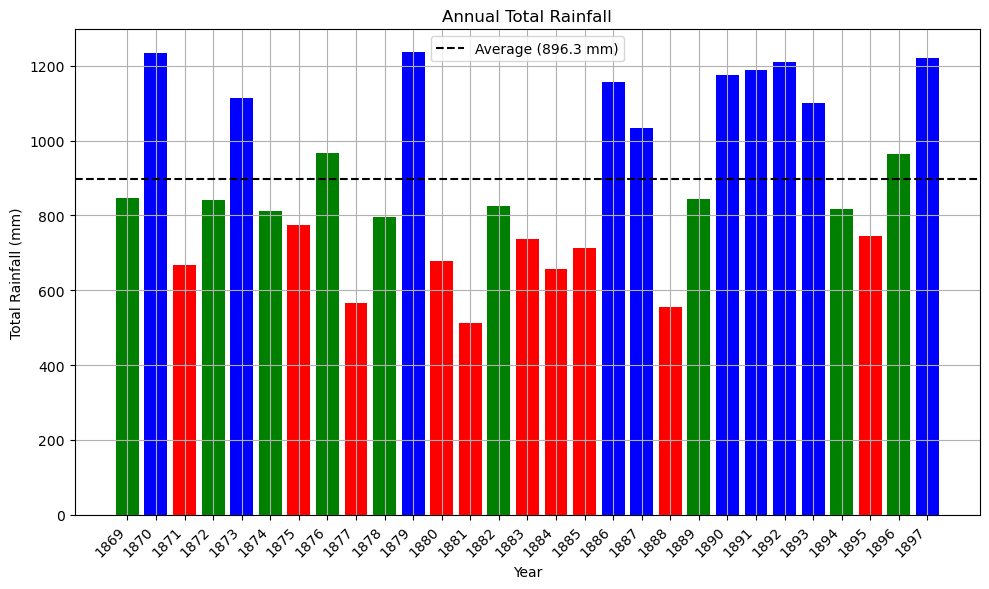

In [22]:

# Function to filter out months based on missing values
def filter_months(df, missing_threshold=5, consecutive_missing_threshold=3):
    filtered_months = []
    for year in df['year'].unique():
        for month in df[df['year'] == year]['month'].unique():
            month_data = df[(df['year'] == year) & (df['month'] == month)]
            missing_count = month_data['prcp'].eq(-99.9).sum()
            if missing_count > missing_threshold:
                filtered_months.append((year, month))
            else:
                consecutive_missing = 0
                for i in range(len(month_data['prcp'])):
                    if month_data['prcp'].iloc[i] == -99.9:
                        consecutive_missing += 1
                        if consecutive_missing >= consecutive_missing_threshold:
                            filtered_months.append((year, month))
                            break
                    else:
                        consecutive_missing = 0
    return filtered_months

filtered_months = filter_months(df, missing_threshold=5, consecutive_missing_threshold=3)
print("Filtered Months:", filtered_months)

# Filtering out months based on missing values
df_filtered = df[~df.apply(lambda x: (x['year'], x['month']) in filtered_months, axis=1)]

# Remove -99.9 values for the remaining data
df_filtered = df_filtered[df_filtered['prcp'] != -99.9]

# Aggregate total rainfall values for each year
annual_total_rainfall = df_filtered.groupby('year')['prcp'].sum()

# Calculate average total annual rainfall and standard deviation
average_annual_rainfall = annual_total_rainfall.mean()
std_annual_rainfall = annual_total_rainfall.std()

# Plot the graph for annual total rainfall with average line
plt.figure(figsize=(10, 6))

# Plot average line
plt.axhline(average_annual_rainfall, color='black', linestyle='--', label=f'Average ({average_annual_rainfall:.1f} mm)')

# Plot annual total rainfall bars
for year, rainfall in annual_total_rainfall.iteritems():
    deviation = rainfall - average_annual_rainfall
    if deviation <= -0.5 * std_annual_rainfall:
        color = 'red'
    elif deviation >= 0.5 * std_annual_rainfall:
        color = 'blue'
    else:
        color = 'green'
    plt.bar(year, rainfall, color=color)

plt.title('Annual Total Rainfall')
plt.xlabel('Year')
plt.ylabel('Total Rainfall (mm)')
plt.grid(True)
plt.xticks(annual_total_rainfall.index, rotation=45, ha='right')  # Rotate x-axis ticks for better readability
plt.legend()
plt.tight_layout()
plt.show()

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from scipy.ndimage import gaussian_filter
from scipy.stats import gaussian_kde

# Define directories and file paths
input_directory = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Rainfall Stored values for R1_99 Events'
output_directory = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/BoM Station Dataset/Map_IDW_KDE_plots'
shapefile_path = '/Users/coolkarni/Documents/Documents/Documents/Master thesis Data/combined_shapefile.shp'
excel_file_path = '/Users/coolkarni/Desktop/OneDrive - The University of Melbourne/R1_99_New Events.xlsx'  # Replace with the actual path to your Excel file

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Read the shapefile
gdf = gpd.read_file(shapefile_path)

# Get the bounds of the shapefile
minx, miny, maxx, maxy = gdf.total_bounds

# Create a grid of points within the bounds
xi, yi = np.meshgrid(np.linspace(minx, maxx, 100), np.linspace(miny, maxy, 100))
zi = np.zeros(xi.shape)

# Read the Excel file and get the event names
excel_df = pd.read_excel(excel_file_path, sheet_name='Sheet7')
event_names = excel_df['Event'].dropna().unique()

# Function to perform Gaussian KDE
def perform_gaussian_kde(latitude, longitude, rainfall):
    try:
        xy = np.vstack([longitude, latitude])
        kde = gaussian_kde(xy, weights=rainfall, bw_method='scott')
        zi = kde(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)
        zi_smoothed = gaussian_filter(zi, sigma=2)
        return zi_smoothed, None
    except Exception as e:
        return None, str(e)

# Function to perform IDW interpolation
def perform_idw(latitude, longitude, rainfall):
    try:
        for i in range(len(xi)):
            for j in range(len(yi)):
                distances = np.sqrt((longitude.values - xi[i, j])**2 + (latitude.values - yi[i, j])**2)
                weights = 1 / (distances + 1e-6)
                zi[i, j] = np.sum(weights * rainfall.values) / np.sum(weights)
        zi_smoothed = gaussian_filter(zi, sigma=2)
        return zi_smoothed, None
    except Exception as e:
        return None, str(e)

# Process each event
for event_name in event_names:
    try:
        # Construct the CSV file path
        csv_file_name = f'{event_name}.csv'
        csv_file_path = os.path.join(input_directory, csv_file_name)

        # Load the CSV file
        df = pd.read_csv(csv_file_path)

        # Extract necessary columns
        latitude = df['Latitude']
        longitude = df['Longitude']

        # Interpolate the rainfall data on the grid for each day
        rainfall_columns = [col for col in df.columns if 'Rainfall' in col]
        daily_means = []

        # Store peak points and colors
        peak_points = []
        peak_colors = []
        method_used = ""

        for col in rainfall_columns:
            method_used = ""  # Initialize method_used inside the loop
            x_cleaned = df[['Latitude', 'Longitude', col]].dropna()
            rainfall = x_cleaned[col]
            latitude = x_cleaned['Latitude']
            longitude = x_cleaned['Longitude']

            # First try Gaussian KDE method
            zi_smoothed, error = perform_gaussian_kde(latitude, longitude, rainfall)
            if error:
                print(f'Gaussian KDE failed for {event_name} on column {col}: {error}')
                # If KDE fails, try IDW method
                zi_smoothed, error = perform_idw(latitude, longitude, rainfall)
                if error:
                    print(f'IDW interpolation failed for {event_name} on column {col}: {error}')
                    continue
                else:
                    method_used = "IDW"
            else:
                method_used = "Gaussian KDE"

            # Detect the highest peak (center of the contour)
            peak_index = np.unravel_index(np.nanargmax(zi_smoothed), zi_smoothed.shape)
            peak_y, peak_x = peak_index

            # Mask the grid to include only points inside the shapefile geometry
            points = np.vstack((xi.flatten(), yi.flatten())).T
            mask = np.array([gdf.contains(Point(point)).any() for point in points])
            mask = mask.reshape(xi.shape)
            zi_smoothed = np.where(mask, zi_smoothed, np.nan)

            # Extract stations within the 90th percentile of the highest shaded contour
            contour_level = np.percentile(zi_smoothed[~np.isnan(zi_smoothed)], 90)
            contour_stations = x_cleaned[(zi_smoothed[(np.digitize(latitude, yi[:, 0]), np.digitize(longitude, xi[0]))] >= contour_level)]

            # Extract top 5 stations with highest rainfall
            top_stations = contour_stations.nlargest(5, col)

            # Apply .describe() to these stations
            top_stations_description = top_stations.describe()

            # Calculate daily mean rainfall
            daily_mean = top_stations[col].mean()
            daily_means.append(daily_mean)

            # Store peak points
            peak_points.append((xi[peak_y, peak_x], yi[peak_y, peak_x]))

        # Calculate total mean of all daily means and 25th percentile
        total_mean = np.mean(daily_means)
        percentile_25th = np.percentile(daily_means, 25)

        # Determine peak colors based on the 25th percentile
        peak_colors = ['red' if mean > percentile_25th else 'green' for mean in daily_means]

        # Plotting the map with peaks connected by lines and annotated
        fig, ax = plt.subplots(figsize=(10, 8))
        gdf.plot(ax=ax, color='gray', edgecolor='none')

        # Plot contours
        for col in rainfall_columns:
            x_cleaned = df[['Latitude', 'Longitude', col]].dropna()
            rainfall = x_cleaned[col]
            latitude = x_cleaned['Latitude']
            longitude = x_cleaned['Longitude']

            # First try Gaussian KDE method
            zi_smoothed, error = perform_gaussian_kde(latitude, longitude, rainfall)
            if error:
                # If KDE fails, try IDW method
                zi_smoothed, error = perform_idw(latitude, longitude, rainfall)

            if zi_smoothed is not None:
                points = np.vstack((xi.flatten(), yi.flatten())).T
                mask = np.array([gdf.contains(Point(point)).any() for point in points])
                mask = mask.reshape(xi.shape)
                zi_smoothed = np.where(mask, zi_smoothed, np.nan)

        

        # Connect peaks with lines and annotate
        for i, (point, color) in enumerate(zip(peak_points, peak_colors)):
            ax.plot(point[0], point[1], 'o', color=color)
            if i > 0 and color == 'red' and peak_colors[i - 1] == 'red':
                prev_point = peak_points[i - 1]
                ax.plot([prev_point[0], point[0]], [prev_point[1], point[1]], color='red')
            ax.annotate(f'{i+1}', xy=point, xytext=(5, -5), textcoords='offset points')

        # Set the title to the event name
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(f'({event_name})')

        # Save the plot
        output_file_path = os.path.join(output_directory, f'{event_name}.png')
        plt.savefig(output_file_path)
        plt.close()

        print(f'Successfully processed: {event_name} using {method_used} method')

    except Exception as e:
        print(f'Error processing {event_name}: {e}')


Successfully processed: Event 916 - 1887-07-27 to 1887-08-02 using Gaussian KDE method
Successfully processed: Event 917 - 1887-09-28 to 1887-10-04 using Gaussian KDE method
Successfully processed: Event 918 - 1888-11-15 to 1888-11-21 using Gaussian KDE method
Successfully processed: Event 919 - 1889-09-05 to 1889-09-11 using Gaussian KDE method
Successfully processed: Event 920 - 1890-07-04 to 1890-07-10 using Gaussian KDE method
Successfully processed: Event 921 - 1876-11-12 to 1876-11-18 using Gaussian KDE method
Successfully processed: Event 922 - 1889-06-11 to 1889-06-17 using Gaussian KDE method
Successfully processed: Event 923 - 1898-10-24 to 1898-10-30 using Gaussian KDE method
Gaussian KDE failed for Event 924 - 1858-12-14 to 1858-12-20 on column Rainfall 1858-12-15: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 924 - 1858-12-14 to 1858-12-20 on column Rainfall 1858-12-16: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 924 - 1858-12-14 to 1858-12-20 on column Rainfall 1858-12-17: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_di

Successfully processed: Event 924 - 1858-12-14 to 1858-12-20 using Gaussian KDE method
Gaussian KDE failed for Event 925 - 1859-01-04 to 1859-01-10 on column Rainfall 1859-01-04: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_di

Gaussian KDE failed for Event 925 - 1859-01-04 to 1859-01-10 on column Rainfall 1859-01-05: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_di

Successfully processed: Event 925 - 1859-01-04 to 1859-01-10 using Gaussian KDE method


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 926 - 1860-03-01 to 1860-03-07 on column Rainfall 1860-03-06: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 926 - 1860-03-01 to 1860-03-07 on column Rainfall 1860-03-07: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_di

Successfully processed: Event 926 - 1860-03-01 to 1860-03-07 using IDW method
Gaussian KDE failed for Event 927 - 1861-01-15 to 1861-01-21 on column Rainfall 1861-01-19: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
Successfully processed: Event 927 - 1861-01-15 to 1861-01-21 using Gaussian KDE method
Gaussian KDE failed for Event 928 - 1861-11-19 to 1861-11-25 on column Rainfall 1861-11-19: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 928 - 1861-11-19 to 1861-11-25 on column Rainfall 1861-11-25: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 928 - 1861-11-19 to 1861-11-25 using IDW method
Successfully processed: Event 929 - 1891-07-23 to 1891-07-29 using Gaussian KDE method
Gaussian KDE failed for Event 930 - 1858-03-20 to 1858-03-26 on column Rainfall 1858-03-20: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 930 - 1858-03-20 to 1858-03-26 on column Rainfall 1858-03-21: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 930 - 1858-03-20 to 1858-03-26 using Gaussian KDE method
Gaussian KDE failed for Event 931 - 1859-02-12 to 1859-02-18 on column Rainfall 1859-02-12: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 931 - 1859-02-12 to 1859-02-18 on column Rainfall 1859-02-13: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 931 - 1859-02-12 to 1859-02-18 on column Rainfall 1859-02-14: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 931 - 1859-02-12 to 1859-02-18 on column Rainfall 1859-02-15: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, r

Successfully processed: Event 931 - 1859-02-12 to 1859-02-18 using Gaussian KDE method
Gaussian KDE failed for Event 932 - 1859-11-13 to 1859-11-19 on column Rainfall 1859-11-13: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 932 - 1859-11-13 to 1859-11-19 on column Rainfall 1859-11-14: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 932 - 1859-11-13 to 1859-11-19 using Gaussian KDE method


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 933 - 1861-02-01 to 1861-02-07 on column Rainfall 1861-02-02: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 933 - 1861-02-01 to 1861-02-07 on column Rainfall 1861-02-03: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 933 - 1861-02-01 to 1861-02-07 on column Rainfall 1861-02-06: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_di

Successfully processed: Event 933 - 1861-02-01 to 1861-02-07 using Gaussian KDE method
Gaussian KDE failed for Event 934 - 1861-06-22 to 1861-06-28 on column Rainfall 1861-06-22: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 934 - 1861-06-22 to 1861-06-28 on column Rainfall 1861-06-23: array must not contain infs or NaNs
Gaussian KDE failed for Event 934 - 1861-06-22 to 1861-06-28 on column Rainfall 1861-06-24: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 934 - 1861-06-22 to 1861-06-28 on column Rainfall 1861-06-27: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 934 - 1861-06-22 to 1861-06-28 on column Rainfall 1861-06-28: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 934 - 1861-06-22 to 1861-06-28 using IDW method
Successfully processed: Event 935 - 1861-07-22 to 1861-07-28 using Gaussian KDE method
Gaussian KDE failed for Event 936 - 1863-01-23 to 1863-01-29 on column Rainfall 1863-01-28: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
Successfully processed: Event 936 - 1863-01-23 to 1863-01-29 using Gaussian KDE method
Gaussian KDE failed for Event 937 - 1863-02-12 to 1863-02-18 on column Rainfall 1863-02-12: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 937 - 1863-02-12 to 1863-02-18 on column Rainfall 1863-02-13: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Successfully processed: Event 937 - 1863-02-12 to 1863-02-18 using Gaussian KDE method


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 938 - 1863-03-30 to 1863-04-05 on column Rainfall 1863-03-31: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 938 - 1863-03-30 to 1863-04-05 on column Rainfall 1863-04-03: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 938 - 1863-03-30 to 1863-04-05 on column Rainfall 1863-04-04: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 938 - 1863-03-30 to 1863-04-05 on column Rainfall 1863-04-05: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, r

Successfully processed: Event 938 - 1863-03-30 to 1863-04-05 using IDW method


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 939 - 1863-04-20 to 1863-04-26 on column Rainfall 1863-04-26: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Successfully processed: Event 939 - 1863-04-20 to 1863-04-26 using IDW method


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 940 - 1863-10-21 to 1863-10-27 on column Rainfall 1863-10-22: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 940 - 1863-10-21 to 1863-10-27 on column Rainfall 1863-10-25: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 940 - 1863-10-21 to 1863-10-27 using Gaussian KDE method
Gaussian KDE failed for Event 941 - 1864-02-20 to 1864-02-26 on column Rainfall 1864-02-20: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 941 - 1864-02-20 to 1864-02-26 on column Rainfall 1864-02-21: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 941 - 1864-02-20 to 1864-02-26 on column Rainfall 1864-02-22: array must not contain infs or NaNs
Gaussian KDE failed for Event 941 - 1864-02-20 to 1864-02-26 on column Rainfall 1864-02-23: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 941 - 1864-02-20 to 1864-02-26 on column Rainfall 1864-02-24: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 941 - 1864-02-20 to 1864-02-26 on column Rainfall 1864-02-25: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 941 - 1864-02-20 to 1864-02-26 on column Rainfall 1864-02-26: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/l

Successfully processed: Event 941 - 1864-02-20 to 1864-02-26 using IDW method
Successfully processed: Event 942 - 1871-12-25 to 1871-12-31 using Gaussian KDE method
Successfully processed: Event 943 - 1875-04-20 to 1875-04-26 using Gaussian KDE method
Successfully processed: Event 944 - 1875-08-07 to 1875-08-13 using Gaussian KDE method
Gaussian KDE failed for Event 945 - 1876-06-23 to 1876-06-29 on column Rainfall 1876-06-23: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
Successfully processed: Event 945 - 1876-06-23 to 1876-06-29 using Gaussian KDE method
Gaussian KDE failed for Event 946 - 1876-10-27 to 1876-11-02 on column Rainfall 1876-10-27: The data appears to lie in a lower-

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 946 - 1876-10-27 to 1876-11-02 on column Rainfall 1876-10-28: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 946 - 1876-10-27 to 1876-11-02 on column Rainfall 1876-10-31: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 946 - 1876-10-27 to 1876-11-02 on column Rainfall 1876-11-01: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 946 - 1876-10-27 to 1876-11-02 on column Rainfall 1876-11-02: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, r

Successfully processed: Event 946 - 1876-10-27 to 1876-11-02 using IDW method
Successfully processed: Event 947 - 1879-01-22 to 1879-01-28 using Gaussian KDE method
Successfully processed: Event 948 - 1881-01-26 to 1881-02-01 using Gaussian KDE method
Successfully processed: Event 949 - 1897-11-12 to 1897-11-18 using Gaussian KDE method
Successfully processed: Event 950 - 1897-12-22 to 1897-12-28 using Gaussian KDE method
Gaussian KDE failed for Event 951 - 1859-06-06 to 1859-06-12 on column Rainfall 1859-06-07: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 951 - 1859-06-06 to 1859-06-12 on column Rainfall 1859-06-11: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 951 - 1859-06-06 to 1859-06-12 on column Rainfall 1859-06-12: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 951 - 1859-06-06 to 1859-06-12 using IDW method
Gaussian KDE failed for Event 952 - 1859-10-30 to 1859-11-05 on column Rainfall 1859-10-31: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 952 - 1859-10-30 to 1859-11-05 on column Rainfall 1859-11-03: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 952 - 1859-10-30 to 1859-11-05 on column Rainfall 1859-11-05: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 952 - 1859-10-30 to 1859-11-05 using IDW method
Successfully processed: Event 953 - 1860-04-19 to 1860-04-25 using Gaussian KDE method
Gaussian KDE failed for Event 954 - 1860-05-20 to 1860-05-26 on column Rainfall 1860-05-20: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 954 - 1860-05-20 to 1860-05-26 on column Rainfall 1860-05-21: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 954 - 1860-05-20 to 1860-05-26 on column Rainfall 1860-05-22: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Successfully processed: Event 954 - 1860-05-20 to 1860-05-26 using Gaussian KDE method
Gaussian KDE failed for Event 955 - 1860-06-22 to 1860-06-28 on column Rainfall 1860-06-22: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 955 - 1860-06-22 to 1860-06-28 on column Rainfall 1860-06-23: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 955 - 1860-06-22 to 1860-06-28 on column Rainfall 1860-06-27: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 955 - 1860-06-22 to 1860-06-28 on column Rainfall 1860-06-28: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, r

Successfully processed: Event 955 - 1860-06-22 to 1860-06-28 using IDW method
Gaussian KDE failed for Event 956 - 1860-10-17 to 1860-10-23 on column Rainfall 1860-10-17: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 956 - 1860-10-17 to 1860-10-23 on column Rainfall 1860-10-18: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 956 - 1860-10-17 to 1860-10-23 on column Rainfall 1860-10-23: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 956 - 1860-10-17 to 1860-10-23 using IDW method
Gaussian KDE failed for Event 957 - 1860-11-20 to 1860-11-26 on column Rainfall 1860-11-21: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 957 - 1860-11-20 to 1860-11-26 on column Rainfall 1860-11-22: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 957 - 1860-11-20 to 1860-11-26 on column Rainfall 1860-11-23: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 957 - 1860-11-20 to 1860-11-26 on column Rainfall 1860-11-26: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_di

Successfully processed: Event 957 - 1860-11-20 to 1860-11-26 using IDW method
Gaussian KDE failed for Event 958 - 1861-11-27 to 1861-12-03 on column Rainfall 1861-11-28: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
Successfully processed: Event 958 - 1861-11-27 to 1861-12-03 using Gaussian KDE method
Successfully processed: Event 959 - 1870-10-23 to 1870-10-29 using Gaussian KDE method
Successfully processed: Event 960 - 1871-09-16 to 1871-09-22 using Gaussian KDE method
Gaussian KDE failed for Event 961 - 1875-08-28 to 1875-09-03 on column Rainfall 1875-08-28: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_di

Gaussian KDE failed for Event 961 - 1875-08-28 to 1875-09-03 on column Rainfall 1875-08-29: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_di

Successfully processed: Event 961 - 1875-08-28 to 1875-09-03 using Gaussian KDE method
Gaussian KDE failed for Event 962 - 1876-09-19 to 1876-09-25 on column Rainfall 1876-09-19: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 962 - 1876-09-19 to 1876-09-25 on column Rainfall 1876-09-20: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Successfully processed: Event 962 - 1876-09-19 to 1876-09-25 using Gaussian KDE method
Successfully processed: Event 963 - 1878-03-13 to 1878-03-19 using Gaussian KDE method
Successfully processed: Event 964 - 1896-09-14 to 1896-09-20 using Gaussian KDE method
Successfully processed: Event 965 - 1890-03-31 to 1890-04-06 using Gaussian KDE method
Successfully processed: Event 966 - 1896-12-25 to 1896-12-31 using Gaussian KDE method
Successfully processed: Event 967 - 1889-01-18 to 1889-01-24 using Gaussian KDE method
Gaussian KDE failed for Event 968 - 1889-11-26 to 1889-12-02 on column Rainfall 1889-11-28: aweights cannot be negative
Successfully processed: Event 968 - 1889-11-26 to 1889-12-02 using Gaussian KDE method
Successfully processed: Event 969 - 1893-03-19 to 1893-03-25 using Gaussian KDE method
Successfully processed: Event 970 - 1896-01-19 to 1896-01-25 using Gaussian KDE method
Gaussian KDE failed for Event 971 - 1882-11-20 to 1882-11-26 on column Rainfall 1882-11-22: aweig

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 971 - 1882-11-20 to 1882-11-26 on column Rainfall 1882-11-24: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 971 - 1882-11-20 to 1882-11-26 using Gaussian KDE method
Gaussian KDE failed for Event 972 - 1891-10-25 to 1891-10-31 on column Rainfall 1891-10-31: aweights cannot be negative
Successfully processed: Event 972 - 1891-10-25 to 1891-10-31 using IDW method
Successfully processed: Event 973 - 1892-04-10 to 1892-04-16 using Gaussian KDE method
Successfully processed: Event 974 - 1890-06-21 to 1890-06-27 using Gaussian KDE method
Successfully processed: Event 975 - 1875-02-16 to 1875-02-22 using Gaussian KDE method
Successfully processed: Event 976 - 1898-02-27 to 1898-03-05 using Gaussian KDE method
Successfully processed: Event 977 - 1892-08-20 to 1892-08-26 using Gaussian KDE method
Gaussian KDE failed for Event 978 - 1885-09-07 to 1885-09-13 on column Rainfall 1885-09-07: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the alg

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 986 - 1878-03-28 to 1878-04-03 on column Rainfall 1878-03-30: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 986 - 1878-03-28 to 1878-04-03 on column Rainfall 1878-04-02: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 986 - 1878-03-28 to 1878-04-03 on column Rainfall 1878-04-03: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divid

Successfully processed: Event 986 - 1878-03-28 to 1878-04-03 using IDW method
Successfully processed: Event 987 - 1880-02-25 to 1880-03-02 using Gaussian KDE method
Successfully processed: Event 988 - 1881-05-01 to 1881-05-07 using Gaussian KDE method
Successfully processed: Event 989 - 1893-12-11 to 1893-12-17 using Gaussian KDE method
Gaussian KDE failed for Event 990 - 1886-11-22 to 1886-11-28 on column Rainfall 1886-11-25: aweights cannot be negative
Successfully processed: Event 990 - 1886-11-22 to 1886-11-28 using Gaussian KDE method
Successfully processed: Event 991 - 1886-12-26 to 1887-01-01 using Gaussian KDE method
Gaussian KDE failed for Event 992 - 1885-12-30 to 1886-01-05 on column Rainfall 1885-12-30: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 992 - 1885-12-30 to 1886-01-05 using Gaussian KDE method
Successfully processed: Event 993 - 1890-12-01 to 1890-12-07 using Gaussian KDE method
Successfully processed: Event 994 - 1870-03-31 to 1870-04-06 using Gaussian KDE method
Gaussian KDE failed for Event 995 - 1870-04-11 to 1870-04-17 on column Rainfall 1870-04-11: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 995 - 1870-04-11 to 1870-04-17 on column Rainfall 1870-04-12: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 995 - 1870-04-11 to 1870-04-17 on column Rainfall 1870-04-13: array must not contain infs or NaNs
Gaussian KDE failed for Event 995 - 1870-04-11 to 1870-04-17 on column Rainfall 1870-04-16: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 995 - 1870-04-11 to 1870-04-17 on column Rainfall 1870-04-17: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Successfully processed: Event 995 - 1870-04-11 to 1870-04-17 using IDW method
Successfully processed: Event 996 - 1870-06-19 to 1870-06-25 using Gaussian KDE method
Successfully processed: Event 997 - 1890-01-03 to 1890-01-09 using Gaussian KDE method
Successfully processed: Event 998 - 1896-03-13 to 1896-03-19 using Gaussian KDE method
Gaussian KDE failed for Event 999 - 1882-06-15 to 1882-06-21 on column Rainfall 1882-06-18: aweights cannot be negative
Successfully processed: Event 999 - 1882-06-15 to 1882-06-21 using Gaussian KDE method
Successfully processed: Event 1000 - 1894-04-11 to 1894-04-17 using Gaussian KDE method
Successfully processed: Event 1001 - 1898-02-23 to 1898-03-01 using Gaussian KDE method
Gaussian KDE failed for Event 1002 - 1872-03-07 to 1872-03-13 on column Rainfall 1872-03-09: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the 

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1013 - 1872-04-30 to 1872-05-06 on column Rainfall 1872-05-01: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1013 - 1872-04-30 to 1872-05-06 on column Rainfall 1872-05-05: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1013 - 1872-04-30 to 1872-05-06 on column Rainfall 1872-05-06: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 1013 - 1872-04-30 to 1872-05-06 using IDW method
Gaussian KDE failed for Event 1014 - 1880-11-21 to 1880-11-27 on column Rainfall 1880-11-26: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
Successfully processed: Event 1014 - 1880-11-21 to 1880-11-27 using Gaussian KDE method
Successfully processed: Event 1015 - 1894-12-22 to 1894-12-28 using Gaussian KDE method


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1016 - 1881-02-05 to 1881-02-11 on column Rainfall 1881-02-11: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 1016 - 1881-02-05 to 1881-02-11 using IDW method
Successfully processed: Event 1017 - 1900-11-21 to 1900-11-27 using Gaussian KDE method
Successfully processed: Event 1018 - 1881-12-01 to 1881-12-07 using Gaussian KDE method
Gaussian KDE failed for Event 1019 - 1882-05-02 to 1882-05-08 on column Rainfall 1882-05-06: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
Successfully processed: Event 1019 - 1882-05-02 to 1882-05-08 using Gaussian KDE method
Successfully processed: Event 1020 - 1882-08-06 to 1882-08-12 using Gaussian KDE method
Gaussian KDE failed for Event 1021 - 1882-10-02 to 1882-10-08 on column Rainfall 1882-10-05: aweights cannot be negative


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1025 - 1884-06-06 to 1884-06-12 on column Rainfall 1884-06-07: array must not contain infs or NaNs
Gaussian KDE failed for Event 1025 - 1884-06-06 to 1884-06-12 on column Rainfall 1884-06-08: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Successfully processed: Event 1025 - 1884-06-06 to 1884-06-12 using Gaussian KDE method
Successfully processed: Event 1026 - 1884-10-01 to 1884-10-07 using Gaussian KDE method
Successfully processed: Event 1027 - 1887-06-03 to 1887-06-09 using Gaussian KDE method
Gaussian KDE failed for Event 1028 - 1887-12-05 to 1887-12-11 on column Rainfall 1887-12-06: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
Successfully processed: Event 1028 - 1887-12-05 to 1887-12-11 using Gaussian KDE method
Successfully processed: Event 1029 - 1894-08-08 to 1894-08-14 using Gaussian KDE method
Successfully processed: Event 1030 - 1873-03-11 to 1873-03-17 using Gaussian KDE method
Successfully processed: 

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1032 - 1877-04-18 to 1877-04-24 on column Rainfall 1877-04-24: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 1032 - 1877-04-18 to 1877-04-24 using IDW method
Successfully processed: Event 1033 - 1878-07-29 to 1878-08-04 using Gaussian KDE method
Successfully processed: Event 1034 - 1875-02-06 to 1875-02-12 using Gaussian KDE method
Gaussian KDE failed for Event 1035 - 1875-09-23 to 1875-09-29 on column Rainfall 1875-09-24: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1035 - 1875-09-23 to 1875-09-29 on column Rainfall 1875-09-29: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 1035 - 1875-09-23 to 1875-09-29 using IDW method
Gaussian KDE failed for Event 1036 - 1875-10-17 to 1875-10-23 on column Rainfall 1875-10-23: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
Successfully processed: Event 1036 - 1875-10-17 to 1875-10-23 using IDW method
Successfully processed: Event 1037 - 1881-08-13 to 1881-08-19 using Gaussian KDE method
Successfully processed: Event 1038 - 1882-04-24 to 1882-04-30 using Gaussian KDE method
Gaussian KDE failed for Event 1039 - 1883-09-10 to 1883-09-16 on column Rainfall 1883-09-12: aweights cannot be negative
Successfully processed: Event 1039 - 1883-09-10 to 1883-09-16 using Gaussian KDE method
Successfu

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1041 - 1867-09-21 to 1867-09-27 on column Rainfall 1867-09-22: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1041 - 1867-09-21 to 1867-09-27 on column Rainfall 1867-09-23: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 1041 - 1867-09-21 to 1867-09-27 using Gaussian KDE method
Gaussian KDE failed for Event 1042 - 1868-01-05 to 1868-01-11 on column Rainfall 1868-01-05: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1042 - 1868-01-05 to 1868-01-11 on column Rainfall 1868-01-06: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1042 - 1868-01-05 to 1868-01-11 on column Rainfall 1868-01-07: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1042 - 1868-01-05 to 1868-01-11 on column Rainfall 1868-01-11: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divid

Successfully processed: Event 1042 - 1868-01-05 to 1868-01-11 using IDW method
Gaussian KDE failed for Event 1043 - 1868-03-25 to 1868-03-31 on column Rainfall 1868-03-25: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1043 - 1868-03-25 to 1868-03-31 on column Rainfall 1868-03-26: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1043 - 1868-03-25 to 1868-03-31 on column Rainfall 1868-03-27: array must not contain infs or NaNs
Gaussian KDE failed for Event 1043 - 1868-03-25 to 1868-03-31 on column Rainfall 1868-03-29: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
Gaussian KDE failed for Event 1043 - 1868-03-25 to 1868-03-31 on column Rainfall 1868-03-31: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` wi

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 1043 - 1868-03-25 to 1868-03-31 using IDW method


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1044 - 1868-11-05 to 1868-11-11 on column Rainfall 1868-11-07: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1044 - 1868-11-05 to 1868-11-11 on column Rainfall 1868-11-11: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_di

Successfully processed: Event 1044 - 1868-11-05 to 1868-11-11 using IDW method


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1045 - 1869-03-22 to 1869-03-28 on column Rainfall 1869-03-23: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1045 - 1869-03-22 to 1869-03-28 on column Rainfall 1869-03-24: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_di

Successfully processed: Event 1045 - 1869-03-22 to 1869-03-28 using Gaussian KDE method
Gaussian KDE failed for Event 1046 - 1869-12-31 to 1870-01-06 on column Rainfall 1869-12-31: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1046 - 1869-12-31 to 1870-01-06 on column Rainfall 1870-01-01: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1046 - 1869-12-31 to 1870-01-06 on column Rainfall 1870-01-02: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1046 - 1869-12-31 to 1870-01-06 on column Rainfall 1870-01-06: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, r

Successfully processed: Event 1046 - 1869-12-31 to 1870-01-06 using IDW method
Gaussian KDE failed for Event 1047 - 1870-01-23 to 1870-01-29 on column Rainfall 1870-01-23: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1047 - 1870-01-23 to 1870-01-29 on column Rainfall 1870-01-24: array must not contain infs or NaNs
Gaussian KDE failed for Event 1047 - 1870-01-23 to 1870-01-29 on column Rainfall 1870-01-25: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1047 - 1870-01-23 to 1870-01-29 on column Rainfall 1870-01-29: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 1047 - 1870-01-23 to 1870-01-29 using IDW method
Gaussian KDE failed for Event 1048 - 1870-02-14 to 1870-02-20 on column Rainfall 1870-02-14: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1048 - 1870-02-14 to 1870-02-20 on column Rainfall 1870-02-15: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1048 - 1870-02-14 to 1870-02-20 on column Rainfall 1870-02-16: array must not contain infs or NaNs
Gaussian KDE failed for Event 1048 - 1870-02-14 to 1870-02-20 on column Rainfall 1870-02-17: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
Gaussian KDE failed for Event 1048 - 1870-02-14 to 1870-02-20 on column Rainfall 1870-02-18: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` wi

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1048 - 1870-02-14 to 1870-02-20 on column Rainfall 1870-02-19: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1048 - 1870-02-14 to 1870-02-20 on column Rainfall 1870-02-20: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/l

Successfully processed: Event 1048 - 1870-02-14 to 1870-02-20 using IDW method


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1049 - 1870-09-05 to 1870-09-11 on column Rainfall 1870-09-06: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Successfully processed: Event 1049 - 1870-09-05 to 1870-09-11 using Gaussian KDE method
Gaussian KDE failed for Event 1050 - 1871-05-04 to 1871-05-10 on column Rainfall 1871-05-04: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
Successfully processed: Event 1050 - 1871-05-04 to 1871-05-10 using Gaussian KDE method
Successfully processed: Event 1051 - 1874-02-25 to 1874-03-03 using Gaussian KDE method


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1052 - 1876-02-06 to 1876-02-12 on column Rainfall 1876-02-12: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Successfully processed: Event 1052 - 1876-02-06 to 1876-02-12 using IDW method
Successfully processed: Event 1053 - 1878-03-05 to 1878-03-11 using Gaussian KDE method
Successfully processed: Event 1054 - 1876-08-03 to 1876-08-09 using Gaussian KDE method
Successfully processed: Event 1055 - 1886-08-24 to 1886-08-30 using Gaussian KDE method
Successfully processed: Event 1056 - 1891-04-05 to 1891-04-11 using Gaussian KDE method
Gaussian KDE failed for Event 1057 - 1858-02-21 to 1858-02-27 on column Rainfall 1858-02-21: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1057 - 1858-02-21 to 1858-02-27 on column Rainfall 1858-02-22: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1057 - 1858-02-21 to 1858-02-27 on column Rainfall 1858-02-26: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1057 - 1858-02-21 to 1858-02-27 on column Rainfall 1858-02-27: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, r

Successfully processed: Event 1057 - 1858-02-21 to 1858-02-27 using IDW method
Gaussian KDE failed for Event 1058 - 1858-11-11 to 1858-11-17 on column Rainfall 1858-11-11: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_di

Gaussian KDE failed for Event 1058 - 1858-11-11 to 1858-11-17 on column Rainfall 1858-11-16: array must not contain infs or NaNs
Gaussian KDE failed for Event 1058 - 1858-11-11 to 1858-11-17 on column Rainfall 1858-11-17: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_di

Successfully processed: Event 1058 - 1858-11-11 to 1858-11-17 using IDW method
Gaussian KDE failed for Event 1059 - 1860-09-28 to 1860-10-04 on column Rainfall 1860-09-28: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1059 - 1860-09-28 to 1860-10-04 on column Rainfall 1860-09-29: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1059 - 1860-09-28 to 1860-10-04 on column Rainfall 1860-09-30: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divid

Successfully processed: Event 1059 - 1860-09-28 to 1860-10-04 using Gaussian KDE method
Gaussian KDE failed for Event 1060 - 1860-12-07 to 1860-12-13 on column Rainfall 1860-12-07: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1060 - 1860-12-07 to 1860-12-13 on column Rainfall 1860-12-08: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1060 - 1860-12-07 to 1860-12-13 on column Rainfall 1860-12-09: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divid

Successfully processed: Event 1060 - 1860-12-07 to 1860-12-13 using Gaussian KDE method
Gaussian KDE failed for Event 1061 - 1861-04-14 to 1861-04-20 on column Rainfall 1861-04-14: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_di

Gaussian KDE failed for Event 1061 - 1861-04-14 to 1861-04-20 on column Rainfall 1861-04-15: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1061 - 1861-04-14 to 1861-04-20 on column Rainfall 1861-04-18: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1061 - 1861-04-14 to 1861-04-20 on column Rainfall 1861-04-19: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1061 - 1861-04-14 to 1861-04-20 on column Rainfall 1861-04-20: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_di

Successfully processed: Event 1061 - 1861-04-14 to 1861-04-20 using IDW method
Successfully processed: Event 1062 - 1863-01-12 to 1863-01-18 using Gaussian KDE method


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1063 - 1863-03-13 to 1863-03-19 on column Rainfall 1863-03-14: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1063 - 1863-03-13 to 1863-03-19 on column Rainfall 1863-03-15: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1063 - 1863-03-13 to 1863-03-19 on column Rainfall 1863-03-19: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_di

Successfully processed: Event 1063 - 1863-03-13 to 1863-03-19 using IDW method
Gaussian KDE failed for Event 1064 - 1863-10-10 to 1863-10-16 on column Rainfall 1863-10-10: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1064 - 1863-10-10 to 1863-10-16 on column Rainfall 1863-10-11: array must not contain infs or NaNs
Gaussian KDE failed for Event 1064 - 1863-10-10 to 1863-10-16 on column Rainfall 1863-10-15: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 1064 - 1863-10-10 to 1863-10-16 using Gaussian KDE method
Gaussian KDE failed for Event 1065 - 1866-01-15 to 1866-01-21 on column Rainfall 1866-01-15: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1065 - 1866-01-15 to 1866-01-21 on column Rainfall 1866-01-16: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1065 - 1866-01-15 to 1866-01-21 on column Rainfall 1866-01-17: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1065 - 1866-01-15 to 1866-01-21 on column Rainfall 1866-01-18: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1065 - 1866-01-15 to 1866-01-21 on column Rainfall 1866-01-20: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1065 - 1866-01-15 to 1866-01-21 on column Rainfall 1866-01-21: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, r

Successfully processed: Event 1065 - 1866-01-15 to 1866-01-21 using IDW method


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1066 - 1867-04-03 to 1867-04-09 on column Rainfall 1867-04-04: array must not contain infs or NaNs
Gaussian KDE failed for Event 1066 - 1867-04-03 to 1867-04-09 on column Rainfall 1867-04-05: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 1066 - 1867-04-03 to 1867-04-09 using Gaussian KDE method
Gaussian KDE failed for Event 1067 - 1867-05-14 to 1867-05-20 on column Rainfall 1867-05-14: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1067 - 1867-05-14 to 1867-05-20 on column Rainfall 1867-05-15: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Successfully processed: Event 1067 - 1867-05-14 to 1867-05-20 using Gaussian KDE method
Successfully processed: Event 1068 - 1898-01-27 to 1898-02-02 using Gaussian KDE method
Successfully processed: Event 1069 - 1883-01-15 to 1883-01-21 using Gaussian KDE method
Successfully processed: Event 1070 - 1871-11-17 to 1871-11-23 using Gaussian KDE method
Gaussian KDE failed for Event 1071 - 1871-12-04 to 1871-12-10 on column Rainfall 1871-12-04: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Successfully processed: Event 1071 - 1871-12-04 to 1871-12-10 using Gaussian KDE method


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1072 - 1872-03-26 to 1872-04-01 on column Rainfall 1872-04-01: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Successfully processed: Event 1072 - 1872-03-26 to 1872-04-01 using IDW method
Successfully processed: Event 1073 - 1900-07-28 to 1900-08-03 using Gaussian KDE method
Successfully processed: Event 1074 - 1894-05-03 to 1894-05-09 using Gaussian KDE method
Gaussian KDE failed for Event 1075 - 1871-09-27 to 1871-10-03 on column Rainfall 1871-09-30: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
Successfully processed: Event 1075 - 1871-09-27 to 1871-10-03 using Gaussian KDE method
Successfully processed: Event 1076 - 1874-03-11 to 1874-03-17 using Gaussian KDE method
Gaussian KDE failed for Event 1077 - 1874-08-27 to 1874-09-02 on column Rainfall 1874-08-27: array must not contain infs 

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_di

Gaussian KDE failed for Event 1077 - 1874-08-27 to 1874-09-02 on column Rainfall 1874-09-01: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1077 - 1874-08-27 to 1874-09-02 on column Rainfall 1874-09-02: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_di

Successfully processed: Event 1077 - 1874-08-27 to 1874-09-02 using IDW method
Successfully processed: Event 1078 - 1887-02-21 to 1887-02-27 using Gaussian KDE method
Successfully processed: Event 1079 - 1890-09-23 to 1890-09-29 using Gaussian KDE method
Successfully processed: Event 1080 - 1900-04-21 to 1900-04-27 using Gaussian KDE method
Successfully processed: Event 1081 - 1889-09-09 to 1889-09-15 using Gaussian KDE method
Successfully processed: Event 1082 - 1887-01-05 to 1887-01-11 using Gaussian KDE method
Successfully processed: Event 1083 - 1898-06-01 to 1898-06-07 using Gaussian KDE method
Successfully processed: Event 1084 - 1891-06-27 to 1891-07-03 using Gaussian KDE method
Successfully processed: Event 1085 - 1891-08-28 to 1891-09-03 using Gaussian KDE method
Gaussian KDE failed for Event 1086 - 1864-09-20 to 1864-09-26 on column Rainfall 1864-09-20: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1086 - 1864-09-20 to 1864-09-26 on column Rainfall 1864-09-21: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1086 - 1864-09-20 to 1864-09-26 on column Rainfall 1864-09-22: array must not contain infs or NaNs
Gaussian KDE failed for Event 1086 - 1864-09-20 to 1864-09-26 on column Rainfall 1864-09-23: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1086 - 1864-09-20 to 1864-09-26 on column Rainfall 1864-09-24: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1086 - 1864-09-20 to 1864-09-26 on column Rainfall 1864-09-25: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1086 - 1864-09-20 to 1864-09-26 on column Rainfall 1864-09-26: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/l

Successfully processed: Event 1086 - 1864-09-20 to 1864-09-26 using IDW method
Gaussian KDE failed for Event 1087 - 1869-10-13 to 1869-10-19 on column Rainfall 1869-10-14: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
Successfully processed: Event 1087 - 1869-10-13 to 1869-10-19 using Gaussian KDE method


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1088 - 1870-07-14 to 1870-07-20 on column Rainfall 1870-07-19: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1088 - 1870-07-14 to 1870-07-20 on column Rainfall 1870-07-20: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Successfully processed: Event 1088 - 1870-07-14 to 1870-07-20 using IDW method


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)


Gaussian KDE failed for Event 1089 - 1871-11-07 to 1871-11-13 on column Rainfall 1871-11-08: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Gaussian KDE failed for Event 1089 - 1871-11-07 to 1871-11-13 on column Rainfall 1871-11-09: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Successfully processed: Event 1089 - 1871-11-07 to 1871-11-13 using Gaussian KDE method
Successfully processed: Event 1090 - 1874-09-11 to 1874-09-17 using Gaussian KDE method
Successfully processed: Event 1091 - 1877-05-20 to 1877-05-26 using Gaussian KDE method
Gaussian KDE failed for Event 1092 - 1880-04-26 to 1880-05-02 on column Rainfall 1880-05-01: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
Successfully processed: Event 1092 - 1880-04-26 to 1880-05-02 using Gaussian KDE method
Successfully processed: Event 1093 - 1872-01-14 to 1872-01-20 using Gaussian KDE method
Gaussian KDE failed for Event 1094 - 1870-10-05 to 1870-10-11 on column Rainfall 1870-10-05: array must not cont

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_di

Gaussian KDE failed for Event 1094 - 1870-10-05 to 1870-10-11 on column Rainfall 1870-10-06: array must not contain infs or NaNs


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_di

Successfully processed: Event 1094 - 1870-10-05 to 1870-10-11 using Gaussian KDE method
Successfully processed: Event 1095 - 1875-05-05 to 1875-05-11 using Gaussian KDE method
Successfully processed: Event 1096 - 1880-11-17 to 1880-11-23 using Gaussian KDE method
Gaussian KDE failed for Event 1097 - 1886-06-20 to 1886-06-26 on column Rainfall 1886-06-23: aweights cannot be negative
Successfully processed: Event 1097 - 1886-06-20 to 1886-06-26 using Gaussian KDE method
Successfully processed: Event 1098 - 1886-08-31 to 1886-09-06 using Gaussian KDE method
Successfully processed: Event 1099 - 1897-06-29 to 1897-07-05 using Gaussian KDE method
Successfully processed: Event 1100 - 1884-03-07 to 1884-03-13 using Gaussian KDE method
